# Import dependencies

In [1]:
from os import listdir
from os.path import join
from cv2 import COLOR_BGR2RGB, cvtColor, imread
import numpy as np
from matplotlib import pyplot

# Set parameters

In [12]:
path = './data/IMG'
sample_image = 'center_2016_12_01_13_37_16_570.jpg'

# Get data

Use data by Udacity.

Source: https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip

Size: 322.8 MB

In [3]:
# Do not execute this cell as it will read all images into memory
stop

data = np.array([imread(join(path, file)) for file in listdir(path)], dtype = 'float32')

NameError: name 'stop' is not defined

# Explore data

In [4]:
print('Count:', len(listdir(path)))

Count: 24108


In [13]:
image = imread(join(path, image_sample))
print('Shape:', image.shape)

Shape: (160, 320, 3)


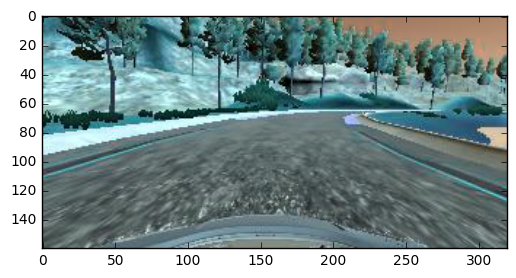

In [7]:
image = cvtColor(image, COLOR_BGR2RGB)
pyplot.imshow(image)
pyplot.show()